In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors
from datetime import datetime

sc = SparkSession.builder.getOrCreate()

In [2]:
# Read the data from the CSV file and return a spark dataframe
df = sc.read.csv("../data/exp3/new/ws_orderinfo_orders_server.csv", header=True, inferSchema=True)
# Drop the incomplete order
df = df.dropna()
print 'order data:', df, '\n'

# Read the order round data
round_df = sc.read.csv("../data/exp3/new/ws_orderinfo_orderinround.csv", header=True, inferSchema=True)
print 'round data:', round_df

order data: DataFrame[id: int, customer: string, red: int, blue: int, green: int, yellow: int, black: int, white: int, pending: int, orderdate: timestamp, tokendate: timestamp, shipdate: timestamp, shipped: int] 

round data: DataFrame[entryid: int, roundid: int, orderid: int]


## 1. Order amount with transition time

In [3]:
def dateformat(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

def timedelta(x, y):
#     return (dateformat(x) - dateformat(y)).total_seconds()
    return (x - y).total_seconds()

# Preprocess the columns to get the time interval between shipping and receiving
data = df.select('shipdate', 'tokendate', 'orderdate', 'red', 'blue', 'green', 'yellow', 'black', 'white').rdd.map(
    lambda x: Row(transitDuration=timedelta(x.shipdate, x.tokendate),
                  fulfillDuration=timedelta(x.shipdate, x.orderdate),
                  amount=(x.red + x.blue + x.green + x.yellow + x.black + x.white))
)
data.take(5)

[Row(amount=18, fulfillDuration=107.0, transitDuration=88.0),
 Row(amount=33, fulfillDuration=215.0, transitDuration=207.0),
 Row(amount=12, fulfillDuration=223.0, transitDuration=91.0),
 Row(amount=22, fulfillDuration=274.0, transitDuration=153.0),
 Row(amount=30, fulfillDuration=348.0, transitDuration=194.0)]

In [4]:
# Convert the data format to ['features', 'label'] for training
train = data.map(lambda x: (Vectors.dense([x.amount]), x.transitDuration)).toDF(["features", "label"])
train.take(5)

[Row(features=DenseVector([18.0]), label=88.0),
 Row(features=DenseVector([33.0]), label=207.0),
 Row(features=DenseVector([12.0]), label=91.0),
 Row(features=DenseVector([22.0]), label=153.0),
 Row(features=DenseVector([30.0]), label=194.0)]

#### Result

In [5]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [3.1261083367618636]
Intercept: 106.690332585
numIterations: 3
objectiveHistory: [0.5, 0.4492707365879532, 0.354728184008306]
RMSE: 44.321169
r2: 0.295769


In [6]:
X = train.rdd.map(lambda x: x.features[0]).collect()
y = train.rdd.map(lambda x: x.label).collect()

p = lrModel.transform(train).select('prediction').rdd.flatMap(list).collect()

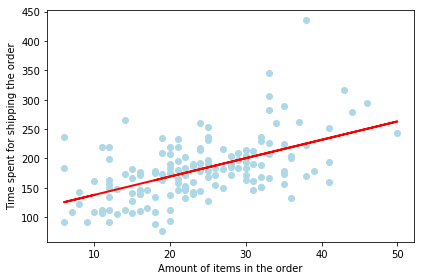

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel('Amount of items in the order')
plt.ylabel('Time spent for shipping the order')
plt.scatter(X, y, c='lightblue')
plt.plot(X, p, color='red', linewidth=2)
plt.tight_layout()
plt.show()

## 2. Order features with Profit

In [8]:
# Get the order features (quantities for each item class)
order_quant_data = df.select('id', 'red', 'blue', 'green', 'yellow', 'black', 'white')
order_quant_data = order_quant_data.withColumn('Total', (
    order_quant_data.red + order_quant_data.blue + order_quant_data.green +
    order_quant_data.yellow + order_quant_data.black + order_quant_data.white
))
order_quant_data.take(5)

[Row(id=1, red=0, blue=5, green=0, yellow=7, black=6, white=0, Total=18),
 Row(id=2, red=7, blue=0, green=7, yellow=9, black=3, white=7, Total=33),
 Row(id=3, red=0, blue=0, green=0, yellow=2, black=8, white=2, Total=12),
 Row(id=4, red=1, blue=4, green=9, yellow=7, black=1, white=0, Total=22),
 Row(id=5, red=9, blue=4, green=6, yellow=0, black=6, white=5, Total=30)]

In [9]:
# Preprocess the round data to get the rounds for each order
round_data = round_df.groupby('orderid').agg({'orderid': 'count'}).sort('orderid')
round_data.take(5)

[Row(orderid=1, count(orderid)=1),
 Row(orderid=2, count(orderid)=3),
 Row(orderid=3, count(orderid)=1),
 Row(orderid=4, count(orderid)=2),
 Row(orderid=5, count(orderid)=2)]

In [10]:
# Join the order data with the round data
order_data = order_quant_data.join(round_data, order_quant_data.id == round_data.orderid)
print 'Record num:', order_data.count()
order_data.take(5)

Record num: 148


[Row(id=1, red=0, blue=5, green=0, yellow=7, black=6, white=0, Total=18, orderid=1, count(orderid)=1),
 Row(id=2, red=7, blue=0, green=7, yellow=9, black=3, white=7, Total=33, orderid=2, count(orderid)=3),
 Row(id=3, red=0, blue=0, green=0, yellow=2, black=8, white=2, Total=12, orderid=3, count(orderid)=1),
 Row(id=4, red=1, blue=4, green=9, yellow=7, black=1, white=0, Total=22, orderid=4, count(orderid)=2),
 Row(id=5, red=9, blue=4, green=6, yellow=0, black=6, white=5, Total=30, orderid=5, count(orderid)=2)]

In [11]:
from pyspark.sql.functions import least, lit

# Calculate the order sales, the formula: Sale of goods (SOGS) + SH
# SOGS = green * 4 + blue * 3 + black * 5 + yellow * 3 + red * 3 + white * 2
# Ship&Handling = max(10, SOGS * 0.1)
order_data = order_data.withColumn('SOGS', (
    order_data.green * 4 + order_data.blue * 3 + order_data.black * 5 +
    order_data.yellow * 3 + order_data.red * 3 + order_data.white * 2
))
order_data = order_data.withColumn('SH', least(order_data.SOGS * 0.1, lit(10.0)))
order_data = order_data.withColumn('Sales', order_data.SOGS + order_data.SH)
order_data.take(5)

[Row(id=1, red=0, blue=5, green=0, yellow=7, black=6, white=0, Total=18, orderid=1, count(orderid)=1, SOGS=66, SH=6.6000000000000005, Sales=72.6),
 Row(id=2, red=7, blue=0, green=7, yellow=9, black=3, white=7, Total=33, orderid=2, count(orderid)=3, SOGS=105, SH=10.0, Sales=115.0),
 Row(id=3, red=0, blue=0, green=0, yellow=2, black=8, white=2, Total=12, orderid=3, count(orderid)=1, SOGS=50, SH=5.0, Sales=55.0),
 Row(id=4, red=1, blue=4, green=9, yellow=7, black=1, white=0, Total=22, orderid=4, count(orderid)=2, SOGS=77, SH=7.7, Sales=84.7),
 Row(id=5, red=9, blue=4, green=6, yellow=0, black=6, white=5, Total=30, orderid=5, count(orderid)=2, SOGS=103, SH=10.0, Sales=113.0)]

In [12]:
# Calculate the order profit, the formula: Sales - COGS - 10 - round * 10 - SH
# COGS = green * 2 + blue * 1.5 + black * 2.5 + yellow * 1.5 + red * 1.5 + white * 1
order_data = order_data.withColumn('COGS', (
    order_data.green * 2 + order_data.blue * 1.5 + order_data.black * 2.5 +
    order_data.yellow * 1.5 + order_data.red * 1.5 + order_data.white * 1
))
order_data = order_data.withColumn('Profit', (
    order_data.Sales - order_data.COGS - lit(10.0) -
    order_data['count(orderid)'] * 10 - order_data.SH
))
print '#Profitable order:', order_data.filter(order_data.Profit > 0).count()
order_data.take(1)

#Profitable order: 121


[Row(id=1, red=0, blue=5, green=0, yellow=7, black=6, white=0, Total=18, orderid=1, count(orderid)=1, SOGS=66, SH=6.6000000000000005, Sales=72.6, COGS=33.0, Profit=12.999999999999993)]

In [13]:
# Convert the data format to ['features', 'label'] for training
# Use the amount of each class of items as features
train = order_data.rdd.map(
    lambda x: (Vectors.dense([x.red, x.blue, x.green, x.yellow, x.black, x.white]),
               x.Profit)).toDF(["features", "label"])
train.take(1)

[Row(features=DenseVector([0.0, 5.0, 0.0, 7.0, 6.0, 0.0]), label=12.999999999999993)]

#### Result

In [14]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [1.0819724973931808,1.0432614963676443,1.522006709857319,0.8665702225930318,2.1009491007340757,0.35094772489658954]
Intercept: -17.3308954197
numIterations: 11
objectiveHistory: [0.49999999999999994, 0.39927416648742303, 0.09314159339213247, 0.09184384487708791, 0.09164518100254655, 0.09163437996705243, 0.09163371516895077, 0.09163370307698655, 0.09163370124424043, 0.09163370122571646, 0.09163370122494173]
RMSE: 3.928364
r2: 0.890853


#### Red with Profit

In [15]:
X = train.rdd.map(lambda x: x.features[0]).collect()
y = train.rdd.map(lambda x: x.label).collect()

p = lrModel.transform(train).select('prediction').rdd.flatMap(list).collect()

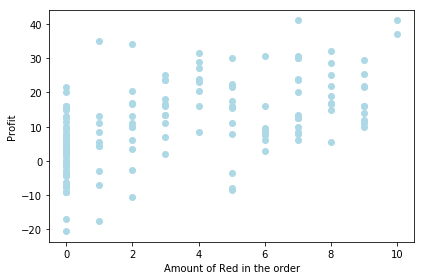

In [16]:
plt.xlabel('Amount of Red in the order')
plt.ylabel('Profit')
plt.scatter(X, y, c='lightblue')
# plt.plot(X, p, color='red', linewidth=2)
plt.tight_layout()
plt.show()

## 3. order, robot with fulfilltime

In [17]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import visuals as vs
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

df_app = pd.read_csv('../data/exp3/new/ws_orderinfo_orders_app.csv', header=0)
df_server = pd.read_csv('../data/exp3/new/ws_orderinfo_orders_server.csv', header=0)
# df_server = df2[["OrderID", "orderdate", "tokendate","shipdate"]]
df_round = pd.read_csv('../data/exp3/new/ws_orderinfo_orderinround.csv', header=0)
df_car = pd.read_csv('../data/exp3/new/ws_orderinfo_carinfo.csv', header=0)

# filtered_df = df[df['orderdate'].isnull()]
df_server = df_server.dropna()
df_server["orderdate"] = df_server["orderdate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_server["tokendate"] = df_server["tokendate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_server["shipdate"] = df_server["shipdate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

df_server["transitDuration"] = (df_server["shipdate"]-df_server["tokendate"])/ np.timedelta64(1, 's')
df_server["fulfillDuration"] = (df_server["shipdate"]-df_server["orderdate"])/ np.timedelta64(1, 's')

df_server["amount"] = df_server["red"]+df_server["blue"]+df_server["yellow"]+df_server["black"]+df_server["white"]

countSplit = [];  # countSplit[0]: number of being split of order 1

for k in xrange(1, len(df_server)+1):
    cluster = [i for i in xrange(len(df_server)) if df_round["orderid"][i]==k]
    countSplit.append(len(cluster))
    
df_server["split"] = df_server["id"].apply(lambda id: countSplit[id-1])

df_car["entermaintence"] = df_car["entermaintence"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_car["exitmaintence"] = df_car["exitmaintence"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_car["maintainDuration"] = (df_car["exitmaintence"]-df_car["entermaintence"])/ np.timedelta64(1, 's')
df_car = df_car[["roundid","maintainDuration"]]
df_app = pd.merge(df_app, df_car, how='left', left_on="id", right_on="roundid")

import numpy as np

df_app.fillna(0)
df_app.fillna(0)

df_app_4= df_app.iloc[[i for i in xrange(len(df_app)) if df_app["carid"][i]==4]][["id","maintainDuration"]]
df_app_12= df_app.iloc[[i for i in xrange(len(df_app)) if df_app["carid"][i]==12]][["id","maintainDuration"]]
# df_app = df_app[["id","maintainDuration"]]
df_round = pd.merge(df_round, df_app[["id","carid"]], how='left', left_on="roundid", right_on="id", suffixes = ["",""])
df_round = df_round[["roundid","orderid","carid"]]

time = 0
count = 1
for index, row in df_app_4.iterrows():
    if np.isnan(row["maintainDuration"]):
        df_app_4["maintainDuration"][index] = time / count
    else:
        time = time + row["maintainDuration"]
        df_app_4["maintainDuration"][index] = time / count
        count = count+1
        
    df_app["maintainDuration"][int(row["id"]-1)] = df_app_4["maintainDuration"][index]
    
time = 0
count = 1
for index, row in df_app_12.iterrows():
    if np.isnan(row["maintainDuration"]):
        df_app_12["maintainDuration"][index] = time / count
    else:
        time = time + row["maintainDuration"]
        df_app_12["maintainDuration"][index] = time / count
        count = count+1
        
    df_app["maintainDuration"][int(row["id"]-1)] = df_app_12["maintainDuration"][index]

df_server["maintain4"] = 0.0
df_server["maintain12"] = 0.0

order2round = {}

for i in xrange(len(df_round)):
    if not order2round.has_key(int(df_round["orderid"][i])-1):
        order2round[int(df_round["orderid"][i])-1] = []
        
    order2round[int(df_round["orderid"][i])-1].append(int(df_round["roundid"][i])-1)
    
for i in xrange(len(df_server)):
    if not order2round.has_key(df_server["id"][i]):
        continue
    rounds = order2round[df_server["id"][i]]
    for r in rounds:
        if df_app["carid"][r]==4:
            df_server["maintain4"][i] =  df_app["maintainDuration"][r]
        else:
            df_server["maintain12"][i] =  df_app["maintainDuration"][r]
df_server[:3]

/Users/changjian/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/changjian/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/changjian/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/changjian/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:75: SettingWit

,id,customer,red,blue,green,yellow,black,white,pending,orderdate,tokendate,shipdate,shipped,transitDuration,fulfillDuration,amount,split,maintain4,maintain12
0,1,Devon,0,5,0,7,6,0,0,2018-07-22 15:00:51,2018-07-22 15:01:10,2018-07-22 15:02:38,1,88.0,107.0,18,1,5.5,0.0
1,2,Erma,7,0,7,9,3,7,0,2018-07-22 15:01:02,2018-07-22 15:01:10,2018-07-22 15:04:37,1,207.0,215.0,26,3,5.5,0.0
2,3,Allen,0,0,0,2,8,2,0,2018-07-22 15:01:13,2018-07-22 15:03:25,2018-07-22 15:04:56,1,91.0,223.0,12,1,5.5,0.0


In [18]:
# Create spark dataframe
data = sc.createDataFrame(df_server)
print data

DataFrame[id: bigint, customer: string, red: bigint, blue: bigint, green: bigint, yellow: bigint, black: bigint, white: bigint, pending: bigint, orderdate: timestamp, tokendate: timestamp, shipdate: timestamp, shipped: bigint, transitDuration: double, fulfillDuration: double, amount: bigint, split: bigint, maintain4: double, maintain12: double]


In [19]:
# Convert the data format to ['features', 'label'] for training
# Use Total amount of items, num of rounds, avg time of maintenance
# for each car as features
train = data.rdd.map(lambda x: (Vectors.dense([x.amount, x.split, x.maintain4, x.maintain12]), x.transitDuration)).toDF(["features", "label"])
train.take(5)

[Row(features=DenseVector([18.0, 1.0, 5.5, 0.0]), label=88.0),
 Row(features=DenseVector([26.0, 3.0, 5.5, 0.0]), label=207.0),
 Row(features=DenseVector([12.0, 1.0, 5.5, 0.0]), label=91.0),
 Row(features=DenseVector([13.0, 2.0, 5.5, 0.0]), label=153.0),
 Row(features=DenseVector([24.0, 2.0, 5.5, 0.0]), label=194.0)]

#### Result

In [20]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
# trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

Coefficients: [3.6894799363617286,-5.904574349670316,-0.2543672405215657,2.611922489997159]
Intercept: 101.419010042
numIterations: 9
objectiveHistory: [0.5, 0.4489091637933565, 0.35114238164820166, 0.3508894552090935, 0.3507823324225764, 0.3507767032107989, 0.3507747989705017, 0.3507747984365294, 0.35077479813797374]
RMSE: 43.996606
r2: 0.306046
